# Digit Recognizer data set

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.utils import plot_model
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

## Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see that the train set contains 42000 rows, each corresponds to an image of a digit represnted by pixel values. The test set contains 28000 images but without the label column.

## Take a look at a few of them

In [7]:
labels = train.label
train.drop('label', axis=1, inplace=True)

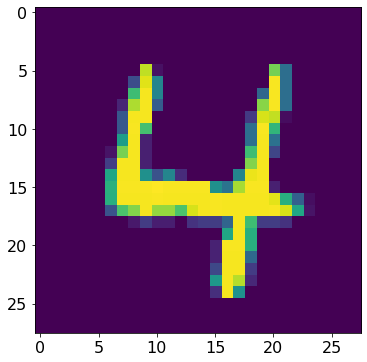

In [8]:
plt.imshow(train.iloc[42].values.reshape((28, 28)))

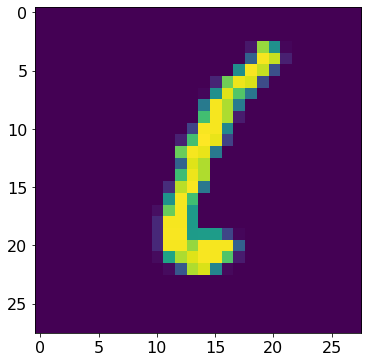

In [9]:
plt.imshow(train.iloc[41275].values.reshape((28, 28)))

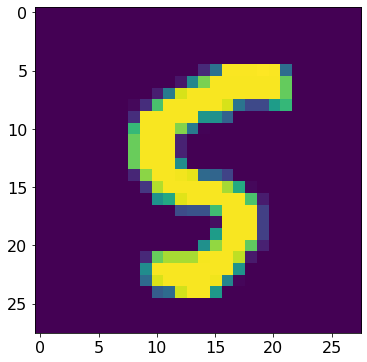

In [10]:
plt.imshow(train.iloc[20452].values.reshape((28, 28)))

## Preprocessing
before we start building a model we first normalize the pixel values, split the training data in to train and validation sets

In [11]:
train = train.values / 255
test = test.values / 255
train = train.reshape((-1, 28, 28, 1))
test = test.reshape((-1, 28, 28, 1))
labels = labels.values
labels = to_categorical(labels)
X_train, X_val, y_train, y_val = train_test_split(train, labels, test_size=0.2)

## Initialize GPU (only for my local machine

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Set Random seed for reproducibility
With GPU this will still give slightly different results

In [13]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_random_seeds()

## Train a simple CNN

In [14]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[28, 28, 1]))
model.add(MaxPool2D(2))
model.add(Dropout(0.5))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [15]:
batch_size = 100
num_epochs = 20
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=num_epochs, validation_data=(X_val, y_val))

Train on 33600 samples, validate on 8400 samples
Epoch 1/20
33600/33600 [==============================] - 3s 84us/sample - loss: 0.7825 - accuracy: 0.7428 - val_loss: 0.2522 - val_accuracy: 0.9265
Epoch 2/20
33600/33600 [==============================] - 1s 31us/sample - loss: 0.3085 - accuracy: 0.9040 - val_loss: 0.1703 - val_accuracy: 0.9464
Epoch 3/20
33600/33600 [==============================] - 1s 37us/sample - loss: 0.2340 - accuracy: 0.9266 - val_loss: 0.1083 - val_accuracy: 0.9670
Epoch 4/20
33600/33600 [==============================] - 1s 31us/sample - loss: 0.1923 - accuracy: 0.9390 - val_loss: 0.1099 - val_accuracy: 0.9656
Epoch 5/20
33600/33600 [==============================] - 1s 29us/sample - loss: 0.1702 - accuracy: 0.9477 - val_loss: 0.0858 - val_accuracy: 0.9733
Epoch 6/20
33600/33600 [==============================] - 1s 38us/sample - loss: 0.1559 - accuracy: 0.9510 - val_loss: 0.0862 - val_accuracy: 0.9726
Epoch 7/20
33600/33600 [==============================] -

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

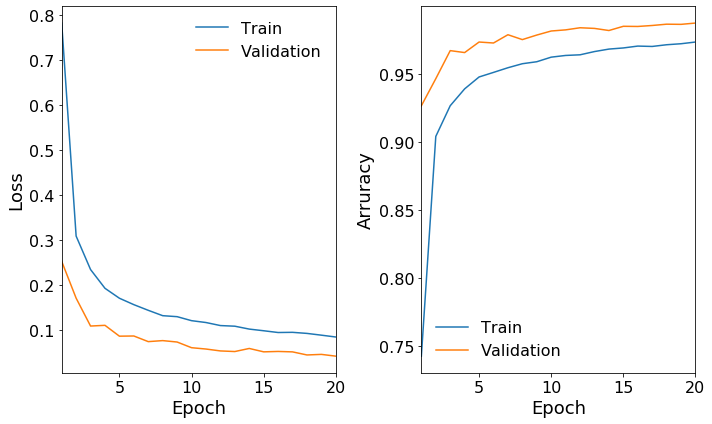

In [16]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(epochs, loss, label='Train')
axes[0].plot(epochs, val_loss, label='Validation')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(frameon=False)
axes[0].autoscale(enable=True, axis='x', tight=True)

axes[1].plot(epochs, acc, label='Train')
axes[1].plot(epochs, val_acc, label='Validation')
axes[1].set_ylabel('Arruracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(frameon=False)
axes[1].autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()

## Make prediction

In [17]:
pred = np.argmax(model.predict(test), axis=1)

In [18]:
from ipywidgets import interact

@interact(index=(0, test.shape[0] - 1))
def plot_test_image(index=0):
    plt.imshow(test[index, :, :, 0])
    plt.title(f'Prediction is {pred[index]}')

interactive(children=(IntSlider(value=0, description='index', max=27999), Output()), _dom_classes=('widget-int…

In [19]:
demo = pd.read_csv('../input/sample_submission.csv')
demo.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [20]:
output = pd.DataFrame({'ImageId': np.arange(1, test.shape[0] + 1), 'Label': pred})
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [21]:
output.to_csv('output.csv', index=False)